In [1]:
!nvidia-smi

Sat Jul 15 13:40:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
## Creating helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-07-15 13:40:05--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-15 13:40:05 (81.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2023-07-15 13:40:09--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.13.128, 74.125.26.128, 172.217.193.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.13.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   181MB/s    in 8.9s    

2023-07-15 13:40:18 (173 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
import zipfile

zip = zipfile.ZipFile("101_food_classes_10_percent.zip")
zip.extractall()
zip.close()


In [6]:
train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

In [7]:
import os

for dirpath, dirname, filename in os.walk("101_food_classes_10_percent"):
  print(f"There are {len(dirname)} directories and {len(filename)} images in path {dirpath}")

There are 2 directories and 0 images in path 101_food_classes_10_percent
There are 101 directories and 0 images in path 101_food_classes_10_percent/test
There are 0 directories and 250 images in path 101_food_classes_10_percent/test/lobster_roll_sandwich
There are 0 directories and 250 images in path 101_food_classes_10_percent/test/poutine
There are 0 directories and 250 images in path 101_food_classes_10_percent/test/pulled_pork_sandwich
There are 0 directories and 250 images in path 101_food_classes_10_percent/test/strawberry_shortcake
There are 0 directories and 250 images in path 101_food_classes_10_percent/test/clam_chowder
There are 0 directories and 250 images in path 101_food_classes_10_percent/test/pad_thai
There are 0 directories and 250 images in path 101_food_classes_10_percent/test/shrimp_and_grits
There are 0 directories and 250 images in path 101_food_classes_10_percent/test/spring_rolls
There are 0 directories and 250 images in path 101_food_classes_10_percent/test/fro

In [8]:
# Setup data inputs
import tensorflow as tf

IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode = "categorical",
                                                                 image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE,
                                                                shuffle = False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* Create a ModelCheckpoint callback
* Create a data augmentaion layer to buid data augmentation right into the model
* Build the headless(no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [9]:
# create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only = True,
                                                         monitor = "val_accuracy",
                                                         save_best_only = True)

In [10]:
# create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentaion = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomZoom(0.2),
    layers.RandomWidth(0.2)
], name = "data_augmentation")

In [11]:
# set the input shape, import the base model and add the data augmentaion layer
input_shape = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create the model architecture with trainable top layers
inputs = tf.keras.layers.Input(shape = input_shape, name = "input_layer")
x = data_augmentaion(inputs)
x = base_model(x, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(len(train_data_all_10_percent.class_names), activation = "softmax")(x)
model = tf.keras.Model(inputs, outputs)


16705208/16705208 [==============================] - 0s 0us/step


In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [13]:
# Compile the model
model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["Accuracy"])

In [14]:
# Fit the model
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
          epochs = 5,
          validation_data = test_data,
          validation_steps = int(0.15 * len(test_data)),
          callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - ETA: 0s - loss: 3.3480 - Accuracy: 0.2767

237/237 [==============================] - 134s 498ms/step - loss: 3.3480 - Accuracy: 0.2767 - val_loss: 2.4222 - val_Accuracy: 0.4780
Epoch 2/5
237/237 [==============================] - ETA: 0s - loss: 2.1961 - Accuracy: 0.4981

237/237 [==============================] - 85s 360ms/step - loss: 2.1961 - Accuracy: 0.4981 - val_loss: 1.9810 - val_Accuracy: 0.5305
Epoch 3/5
237/237 [==============================] - ETA: 0s - loss: 1.8188 - Accuracy: 0.5630

237/237 [==============================] - 65s 273ms/step - loss: 1.8188 - Accuracy: 0.5630 - val_loss: 1.8085 - val_Accuracy: 0.5514
Epoch 4/5
237/237 [==============================] - ETA: 0s - loss: 1.5991 - Accuracy: 0.6150

237/237 [==============================] - 60s 250ms/step - loss: 1.5991 - Accuracy: 0.6150 - val_loss: 1.7455 - val_Accuracy: 0.5490
Epoch 5/5
237/237 [==============================] - ETA: 0s - loss: 1.4443 - Accuracy: 0.6467

237/237 [==============================] - 55s 231ms/step - loss: 1.4443 - Accuracy: 0.6467 - val_loss: 1.6950 - val_Accuracy: 0.5641


In [15]:
# Evaluate on the whole test dataset
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 60s 75ms/step - loss: 1.5909 - Accuracy: 0.5821


[1.5908576250076294, 0.582059383392334]

In [16]:
plot_loss_curves(history_all_classes_10_percent)

KeyError: ignored

## Fine-tuning

In [17]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [18]:
# Recompile the model with lower learning rate (it's typically best practice to lower the learning rate when fine tuning)
model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])

In [19]:
# what layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling2d True
dense True


In [20]:
# What layers in the efficientnetb0 model are trainable
for layer_number,layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [21]:
# Fitting the fine tuned model
tune_epoch = 5
fine_tune_epoch = tune_epoch + 5
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
          epochs = fine_tune_epoch,
          verbose = 1,
          validation_data = test_data,
          validation_steps = int(0.15 * len(test_data)),
          initial_epoch = history_all_classes_10_percent.epoch[-1],
          callbacks = [checkpoint_callback])

Epoch 5/10
237/237 [==============================] - 67s 240ms/step - loss: 1.2129 - accuracy: 0.6832 - val_loss: 1.6660 - val_accuracy: 0.5630
Epoch 6/10
237/237 [==============================] - 52s 215ms/step - loss: 1.0983 - accuracy: 0.7050 - val_loss: 1.6845 - val_accuracy: 0.5575
Epoch 7/10
237/237 [==============================] - 49s 206ms/step - loss: 1.0001 - accuracy: 0.7302 - val_loss: 1.6825 - val_accuracy: 0.5591
Epoch 8/10
237/237 [==============================] - 49s 204ms/step - loss: 0.9431 - accuracy: 0.7496 - val_loss: 1.6417 - val_accuracy: 0.5715
Epoch 9/10
237/237 [==============================] - 46s 195ms/step - loss: 0.8781 - accuracy: 0.7650 - val_loss: 1.6917 - val_accuracy: 0.5585
Epoch 10/10
237/237 [==============================] - 45s 188ms/step - loss: 0.8305 - accuracy: 0.7740 - val_loss: 1.6925 - val_accuracy: 0.5546


In [22]:
# Evaluate the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 64s 81ms/step - loss: 1.5122 - accuracy: 0.5999


[1.5121512413024902, 0.5998811721801758]

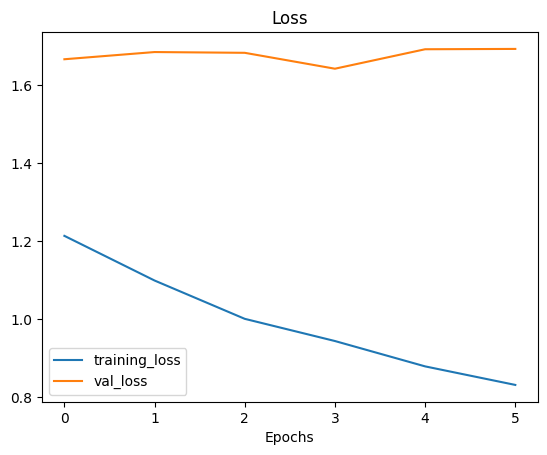

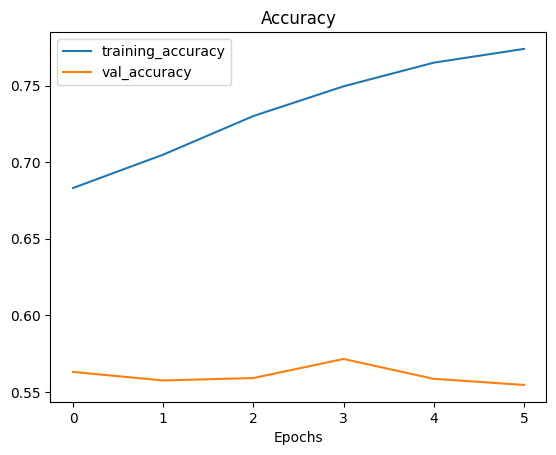

In [23]:
plot_loss_curves(history_all_classes_10_percent_fine_tune)

In [24]:
compare_historys(original_history = history_all_classes_10_percent,
                 new_history = history_all_classes_10_percent_fine_tune,
                 initial_epochs = 5)

KeyError: ignored

## Saving and loading our model

To use our model in an external applicatioans, we'll need to save it and export it somewhere.


In [ ]:
# Save our fine-tuned model
model.save("101_food_classes_saved_big_dog_model")

In [27]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("101_food_classes_saved_big_dog_model")

OSError: ignored

In [ ]:
loaded_model.evaluate(test_data)

In [25]:
model.evaluate(test_data)

790/790 [==============================] - 59s 75ms/step - loss: 1.5122 - accuracy: 0.5999


[1.5121512413024902, 0.5998811721801758]

In [26]:
import tensorflow as tf

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

import zipfile

zip = zipfile.ZipFile("06_101_food_class_10_percent_saved_big_dog_model.zip")
zip.extractall()
zip.close()



--2023-07-15 13:59:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.210.128, 74.125.196.128, 173.194.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.210.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   133MB/s    in 0.3s    

2023-07-15 13:59:22 (133 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [28]:
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 61s 77ms/step - loss: 1.5122 - accuracy: 0.5999


[1.5121512413024902, 0.5998811721801758]

## Making prediction with our trained model

In [29]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose = 1)# set verbosity to see how long is left

790/790 [==============================] - 73s 90ms/step


In [30]:
len(test_data)

790

In [31]:
790*32

25280

In [32]:
# How many prediction are there?
len(preds_probs)

25250

In [34]:
# What's the shape of our predicctions?
preds_probs.shape

(25250, 101)

In [35]:
# let's see what the first then prediction look like
preds_probs[:10]

array([[1.4185244e-01, 3.6911719e-04, 1.7463495e-01, ..., 5.8046776e-06,
        2.5515277e-03, 8.3523309e-03],
       [9.5147055e-01, 3.2290025e-08, 9.4163331e-04, ..., 3.4289691e-03,
        1.5158565e-07, 3.2693185e-06],
       [3.2444310e-01, 1.5049204e-02, 1.0147728e-02, ..., 4.2263771e-04,
        2.8867740e-04, 1.9144651e-03],
       ...,
       [3.3775097e-01, 5.9842946e-06, 6.7564909e-04, ..., 6.0748022e-02,
        3.4583532e-04, 9.2075898e-05],
       [3.1717920e-01, 4.1498593e-04, 1.8014136e-01, ..., 2.6900580e-04,
        1.6127768e-04, 2.6363062e-04],
       [5.1794130e-01, 1.6316988e-06, 1.9632378e-03, ..., 4.6782764e-03,
        4.0285076e-06, 7.8498700e-04]], dtype=float32)

In [38]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([1.4185244e-01, 3.6911719e-04, 1.7463495e-01, 6.9820992e-08,
        9.0343283e-06, 8.3749126e-07, 3.5241363e-05, 1.7373641e-06,
        2.3929130e-02, 3.9570819e-04, 1.3668131e-06, 2.4962701e-06,
        2.0974397e-04, 2.8558739e-07, 3.6036945e-03, 2.4697448e-03,
        3.9021805e-05, 5.3643732e-04, 5.0878478e-03, 3.6770180e-06,
        4.6732524e-04, 8.2751367e-06, 3.9297189e-05, 5.3001117e-05,
        1.5107098e-03, 2.2079968e-03, 4.9703789e-04, 8.4221174e-05,
        1.8609297e-01, 3.8298784e-04, 2.8190252e-06, 5.3448864e-04,
        6.2904204e-04, 9.5292529e-07, 7.5261462e-03, 4.9410651e-06,
        4.9817201e-05, 1.2488419e-03, 2.2512997e-02, 2.1179441e-05,
        5.8726117e-04, 3.0186588e-03, 6.7910361e-05, 6.3756534e-06,
        8.2054401e-05, 9.5328205e-06, 2.9218904e-04, 1.5306333e-04,
        6.0317291e-07, 1.2566595e-01, 2.0346443e-04, 3.6813213e-05,
        1.7646135e-01, 2.4139382e-02, 2.0219124e-05, 1.3461869e-02,
        9.1629140e-03, 2.2909297e-03, 1.5575519e

Our model outputs a prediciton probablity array (with N number of variables, where N is the number os classes) for each sample passed to the predict method.

In [40]:
print(f"Number of prediction probabilities of sample 0: {len(preds_probs[0])}")
print(f"What predicton probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probablity by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities of sample 0: 101
What predicton probability sample 0 looks like:
 [1.4185244e-01 3.6911719e-04 1.7463495e-01 6.9820992e-08 9.0343283e-06
 8.3749126e-07 3.5241363e-05 1.7373641e-06 2.3929130e-02 3.9570819e-04
 1.3668131e-06 2.4962701e-06 2.0974397e-04 2.8558739e-07 3.6036945e-03
 2.4697448e-03 3.9021805e-05 5.3643732e-04 5.0878478e-03 3.6770180e-06
 4.6732524e-04 8.2751367e-06 3.9297189e-05 5.3001117e-05 1.5107098e-03
 2.2079968e-03 4.9703789e-04 8.4221174e-05 1.8609297e-01 3.8298784e-04
 2.8190252e-06 5.3448864e-04 6.2904204e-04 9.5292529e-07 7.5261462e-03
 4.9410651e-06 4.9817201e-05 1.2488419e-03 2.2512997e-02 2.1179441e-05
 5.8726117e-04 3.0186588e-03 6.7910361e-05 6.3756534e-06 8.2054401e-05
 9.5328205e-06 2.9218904e-04 1.5306333e-04 6.0317291e-07 1.2566595e-01
 2.0346443e-04 3.6813213e-05 1.7646135e-01 2.4139382e-02 2.0219124e-05
 1.3461869e-02 9.1629140e-03 2.2909297e-03 1.5575519e-03 3.1749867e-05
 3.0926216e-07 3.7311167e-03 1.7647196e-02 4.07

In [42]:
# test_data.class_names
pred_classes = preds_probs.argmax(axis = 1)
pred_classes[:10]

array([28,  0,  0,  8,  8, 78, 29,  0,  0,  0])

In [43]:
len(pred_classes)

25250

Now we got a predicction array of all of model's predictions, to evaluate them, we need to compare them to the labels

In [44]:
test_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [45]:
len(test_data)

790

In [48]:
y_labels = []
for images,labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10] # look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Evaluate the model's prediction


In [ ]:
results_downloaded_model